## Load required libraries and data

In [176]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from collections import Counter

# disable pandas warnings
pd.options.mode.chained_assignment = None

In [177]:
# Load datasets
visits = pd.read_csv('./dataset/calendar.csv')
reviews = pd.read_csv('./dataset/reviews.csv')
listings = pd.read_csv('./dataset/listings.csv')

## Assess the files

In [178]:
# Check the calendar.csv file's contents
v_num = visits[~visits['price'].isna()].shape[0]
last = visits.sort_values(by='date', ascending=True)['date'].max()
first = visits.sort_values(by='date', ascending=True)['date'].min()
print(f'The calendar.csv file contains {v_num} visits with price points spanning {first} and {last}.')

# Check the reviews.csv file's contents
nb_comments = reviews[~reviews['comments'].isna()].shape[0]
print(f'The reviews.csv file contains {reviews.shape[0]} reviews with {nb_comments} comments.')

# Check the listings.csv file's contents
nb_unique_listings = listings['id'].nunique()
print(f'The listings.csv file contains {nb_unique_listings} unique listings.')

The calendar.csv file contains 643037 visits with price points spanning 2016-09-06 and 2017-09-05.
The reviews.csv file contains 68275 reviews with 68222 comments.
The listings.csv file contains 3585 unique listings.


In [179]:
print(f'The calendar.csv file contains {visits.select_dtypes("object").shape[1]} categorical variables and {visits.select_dtypes(["float64", "int"]).shape[1]} numerical variables.')
print(f'The reviews.csv file contains {reviews.select_dtypes("object").shape[1]} categorical variables and {reviews.select_dtypes(["float64", "int"]).shape[1]} numerical variables.')
print(f'The listings.csv file contains {listings.select_dtypes("object").shape[1]} categorical variables and {listings.select_dtypes(["float64", "int"]).shape[1]} numerical variables.')

The calendar.csv file contains 3 categorical variables and 1 numerical variables.
The reviews.csv file contains 3 categorical variables and 3 numerical variables.
The listings.csv file contains 62 categorical variables and 33 numerical variables.


### Start cleaning first data points  

In [180]:
# Clean and preprocess data
visits['price'] = visits['price'].str.strip('$').str.replace(',','').astype(float)   # convert $ amounts to float
listings.rename(columns={'id': 'listing_id'}, inplace=True)                          # rename the key to easily join files

## What are the most prevalent words in listings' descriptions?

In [181]:
# Count words in listings' descriptions
word_count = Counter()
listings['description'].str.lower().str.split().apply(word_count.update)

# Remove non-informative words to decrease clutter
fluff_words = ['the', 'and', 'at', 'an', 'it\'s', 'or', 'great', 'your', 'all.', 'just', 'as', 'that', 'there', 'we', 
               'have',  'a', 'also', 'to', 'in', 'my', 'is', 'it', 'if', 'of', 'with', 'our', 'has', 'for', 'you', 'be', 
               'on', 'this', 'from', '&', 'i', '-', 'very', 'can', 'will', '2', 'boston', 'are', 'walk']
for fluff in fluff_words:
    if fluff in word_count:
        del word_count[fluff]

In [182]:
word_count.most_common(20)

[('apartment', 2674),
 ('room', 2455),
 ('living', 1845),
 ('bedroom', 1822),
 ('all', 1816),
 ('located', 1750),
 ('private', 1647),
 ('one', 1634),
 ('access', 1593),
 ('kitchen', 1488),
 ('full', 1377),
 ('two', 1350),
 ('place', 1247),
 ('close', 1182),
 ('floor', 1172),
 ('bed', 1137),
 ('back', 1130),
 ('street', 1130),
 ('downtown', 1129),
 ('queen', 1063)]

(-0.5, 999.5, 499.5, -0.5)

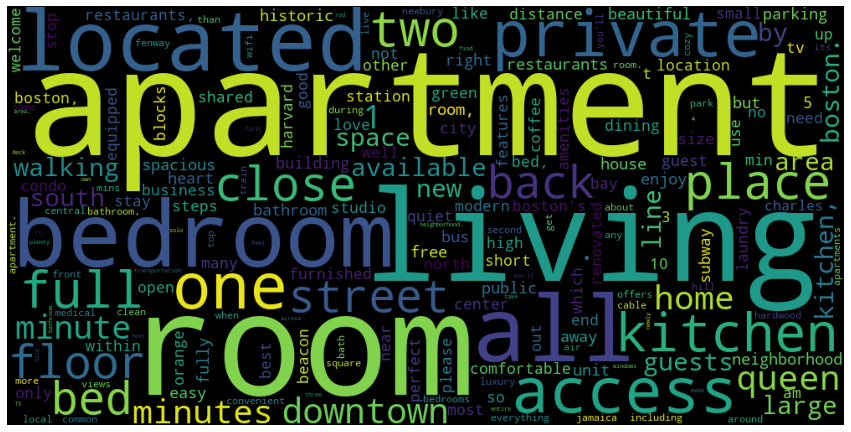

In [183]:
# Plot a word cloud for the most common words
word_count = dict(word_count)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_count)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

## Are satisfaction levels different between price cohorts?

In [184]:
# Add average price per listing based on actual bookings recorded in the dataset rather than declared price
avg_prices = visits.dropna(subset=['price'], how='any', axis=0).groupby(by='listing_id').agg(avg_price=('price','mean'))
listings_w_prices = listings.join(avg_prices, on='listing_id', how='left')
listings_w_prices = listings_w_prices.dropna(axis=1, how='all')

# Label listings with average price quartile
listings_w_prices = listings_w_prices.dropna(subset=['avg_price'], how='any', axis=0)
listings_w_prices['price_quartile'] = pd.qcut(listings_w_prices['avg_price'], q=4, labels=['low', 'low_med', 'high_med', 'high'])

<AxesSubplot:title={'center':'review_scores_rating'}, xlabel='price_quartile'>

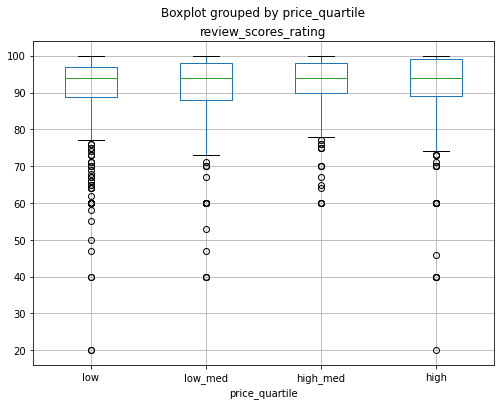

In [185]:
# Plot satisfaction across price quartiles
fig, ax = plt.subplots(figsize=(8,6))
listings_w_prices.boxplot(column=['review_scores_rating'], by='price_quartile', ax=ax)

<AxesSubplot:>

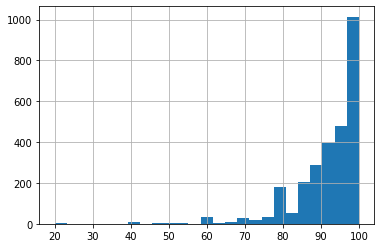

In [186]:
# Plot ratings distribution
listings['review_scores_rating'].hist(bins=25)

## How numerical variables affect prices and satisfaction?

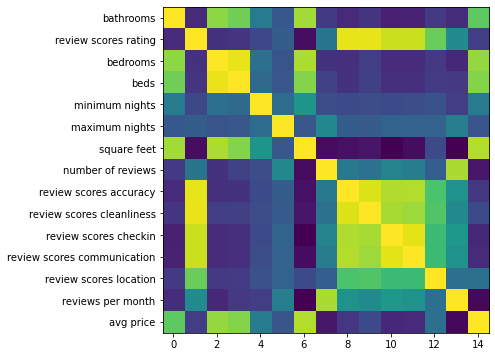

In [187]:
# Analyze correlation between features and price
num_features = ['bathrooms', 'review_scores_rating', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights','square_feet', 'number_of_reviews', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'reviews_per_month', 'avg_price']
listings_num_df = listings_w_prices[num_features]
listings_w_prices_corr = listings_num_df.corr()

# Plot correlation matrix
fig, ax = plt.subplots(figsize=(8,6))
plt.yticks([x for x in range(len(listings_w_prices_corr.columns))], [x.replace('_', ' ') for x in listings_w_prices_corr.columns])
plt.imshow(listings_w_prices_corr.select_dtypes(['float', 'int']).corr())

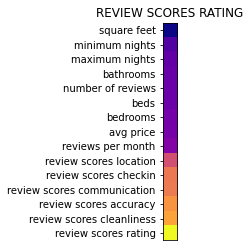

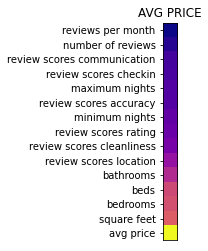

In [188]:
# Get relevant numerical features
num_features = ['bathrooms', 'review_scores_rating', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights','square_feet', 'number_of_reviews', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'reviews_per_month', 'avg_price']

# Check the correlaction with price and score ratings
listings_num_df = listings_w_prices[num_features]
listings_w_prices_corr = listings_num_df.corr()

for stat in ['review_scores_rating', 'avg_price']:
    listings_w_prices_corr = listings_w_prices_corr.sort_values(by=stat)
    plt.yticks([x for x in range(len(listings_w_prices_corr.index))], [x.replace('_', ' ') for x in listings_w_prices_corr.index])
    plt.xticks([])
    plt.title(stat.replace('_', ' ').upper())
    plt.imshow(listings_w_prices_corr[[stat]], cmap='plasma')
    plt.show()

## How features (numerical and categorical) affect the average price?

### Prepare the data

In [189]:
# Get relevant categorical features
cat_features = ['cancellation_policy', 'require_guest_profile_picture', 'require_guest_phone_verification', 'host_is_superhost', 'host_response_time', 'neighbourhood_cleansed', 'host_identity_verified', 'property_type', 'room_type', 'bed_type', 'amenities']
listings_cat_df = listings_w_prices[cat_features]

# Preprocess amenities feature from lists strings
listings_cat_df['amenities'] = listings_cat_df['amenities'].str.replace('{', '', regex=True).str.replace('}', '', regex=True).str.replace('"', '', regex=True).str.lower()
listings_cat_df['amenities'].fillna('x', inplace=True)   # put a placeholder in lieu of empty values

# Get 20 most prevalent amenities
amenities_types = Counter()
listings_cat_df['amenities'].str.lower().str.split(',').apply(amenities_types.update)
amenities_types = [x for x in dict(amenities_types.most_common(20)).keys()]

# Create dummy variables for amenities
for amenity in amenities_types:
    listings_cat_df[amenity] = listings_cat_df['amenities'].apply(lambda x: 1 if x.find(amenity) != -1 else 0)
    
# Drop amenities lists
listings_cat_df.drop(columns=['amenities'], inplace=True)

In [190]:
# Check which numerical features lack more than 50% of values
missing_pct = pd.DataFrame({'missing_pct': round(np.sum(listings_num_df.isna())/listings_num_df.shape[0], 2)})
missing_pct

,missing_pct
bathrooms,0.00
review_scores_rating,0.19
bedrooms,0.00
beds,0.00
minimum_nights,0.00
maximum_nights,0.00
square_feet,0.98
number_of_reviews,0.00
review_scores_accuracy,0.19
review_scores_cleanliness,0.19


In [192]:
# Drop columns with too many missing values
for m in missing_pct[missing_pct['missing_pct']>0.5].index:
    listings_num_df = listings_num_df.drop(columns=[m])
    
# Remove discarded feature from the list of features
for m in missing_pct[missing_pct['missing_pct']>0.5].index:
    num_features.remove(m)

In [193]:
# Replace nulls with columns' mean for numerical variables
listings_num_df[num_features[:-1]] = listings_num_df[num_features[:-1]].fillna(listings_num_df[num_features[:-1]].mean())

# Concatenate numerical and categorical dataframes
ln_df = pd.concat([listings_num_df, listings_cat_df], axis=1)

# Dummy the categorical variables
for col in ln_df.select_dtypes('object').columns:
    ln_df = pd.concat([ln_df.drop(columns=[col]), pd.get_dummies(ln_df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=True)], axis=1)

### Fit and assess the linear model

In [194]:
# Split into features and targets
X = ln_df.drop(columns=['avg_price'], axis=1)
y = ln_df['avg_price']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

# Train linear regression model
linear_model = LinearRegression()                     # Instantiate
linear_model.fit(X_train, y_train)                    # Fit

# Predict and assess the r2 score
y_test_preds = linear_model.predict(X_test)
r2 = r2_score(y_test, y_test_preds)
print(f'R2 score: {r2} using {X.shape[1]} features')

# Display feature importance
coefficients_df = pd.DataFrame({'features': X_train.columns, 'coefficients': linear_model.coef_})

R2 score: 0.3296436064117261 using 95 features


In [195]:
# Show the most underpaid features
print(coefficients_df.sort_values('coefficients', ascending=True).head(20))

                                 features  coefficients
76                property_type_Camper/RV   -196.007805
88                  room_type_Shared room    -88.676644
87                 room_type_Private room    -69.963425
90                         bed_type_Couch    -62.709993
43        host_response_time_within a day    -54.559737
14                                heating    -45.700449
92                 bed_type_Pull-out Sofa    -41.198726
70    neighbourhood_cleansed_West Roxbury    -37.698810
57       neighbourhood_cleansed_Hyde Park    -36.970453
64      neighbourhood_cleansed_Roslindale    -36.457221
85                    property_type_Villa    -34.054300
61        neighbourhood_cleansed_Mattapan    -33.120543
18                         smoke detector    -32.139562
45      host_response_time_within an hour    -31.875047
93                      bed_type_Real Bed    -30.491391
53      neighbourhood_cleansed_Dorchester    -27.374943
91                         bed_type_Futon    -25

In [196]:
# SHow features outside of locations that can add to a bill
print(coefficients_df[~coefficients_df['features'].str.contains('neighbourhood')].sort_values('coefficients', ascending=False).head(20))

                               features  coefficients
2                              bedrooms     55.995784
0                             bathrooms     34.970822
41                  host_is_superhost_t     23.682300
75                   property_type_Boat     22.941152
23                               washer     21.134786
17                     air conditioning     16.028453
26                  family/kid friendly     15.819308
13                    wireless internet     15.333594
35  cancellation_policy_super_strict_30     15.050042
28                           hair dryer     14.765813
82                   property_type_Loft     13.026846
3                                  beds     12.834641
77            property_type_Condominium     12.717181
19                                   tv     11.787032
72             host_identity_verified_t     11.548294
22             carbon monoxide detector     11.364199
30                             cable tv     10.570020
39   require_guest_phone_ver